In [1]:

from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer, fig_3D_ilr_space
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go

In [2]:
K = 10         #Index of the instance you want to test in the test set
N_class = 4    #Number of class, the dimension of the simplex is therefore N_class-1
N_feat  = 6    #In this example, since the number of feature of the digit dataset is quite large (64), we propose to reduce it with a PCA

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
X = scale(X)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Reduce the number of feature to N_feat with a PCA
pca = PCA(n_components=N_feat)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)


#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

SVC(probability=True)

In [3]:

# explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class)
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(Y_test[K])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)

True label of the tested instance: 0
Prediction on the simplex: [[0.99459444 0.00120098 0.00230107 0.0019035 ]]
Prediction in the ILR space: [4.75118826 2.21218478 1.72851812]
Sum of the shapley composition and the base distribution in the ILR space: [4.75118831 2.21218479 1.72851813]


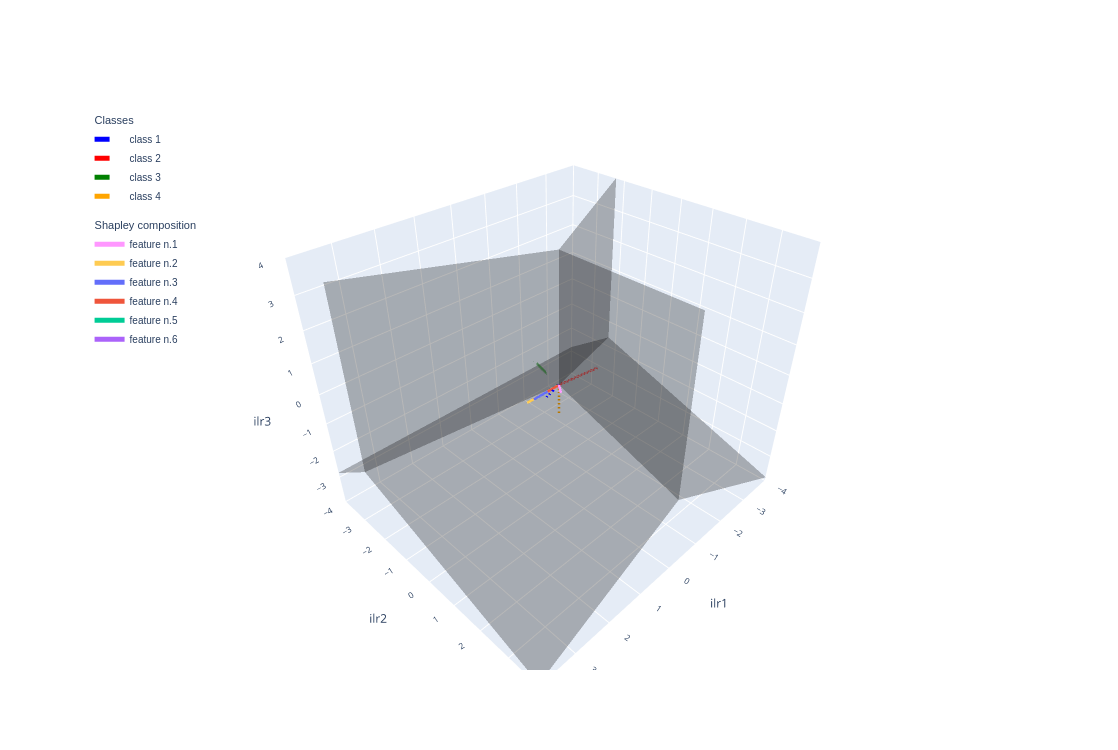

In [8]:
#PLOT THE SHAPLEY COMPOSITION IN THE 3D ILR SPACE (with gram-schmidt basis)

fig = fig_3D_ilr_space(lim=4, figsize=750)

#Draw the shapley compositions
for i,s in enumerate(shapley):
    fig.add_trace(go.Scatter3d(x=[0,s[0]],y=[0,s[1]], z=[0,s[1]], mode='lines', line={'width' : 5}, name='feature n.'+str(i+1),
                             legendgroup='shapley', legendgrouptitle_text='Shapley composition'))

fig.show()

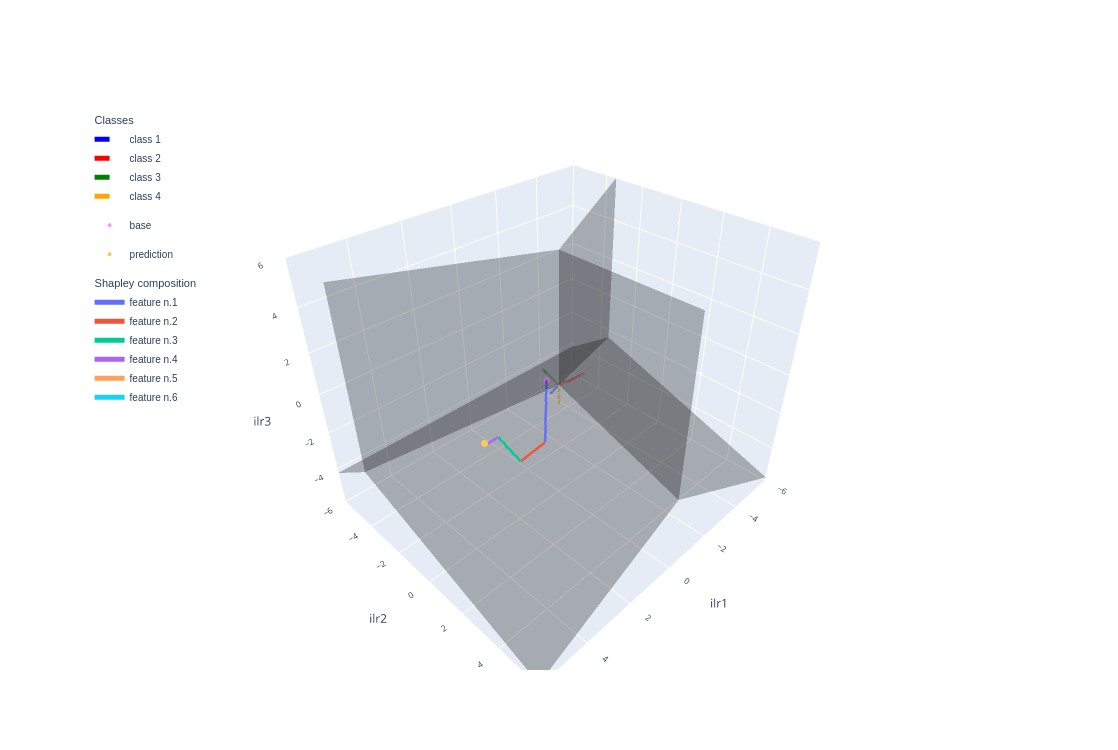

In [9]:
#PLOT THE SHAPLEY COMPOSITION IN THE 3D ILR SPACE (with gram-schmidt basis)

fig = fig_3D_ilr_space(lim=6, figsize=750)


#Draw base distribution and prediction
fig.add_trace(go.Scatter3d(x=[base[0]], y=[base[1]], z=[base[2]], mode='markers', marker={'size' : 4}, name='base'))
fig.add_trace(go.Scatter3d(x=[ilr_pred[0]], y=[ilr_pred[1]], z=[ilr_pred[2]], mode='markers', marker={'size' : 4}, name='prediction'))

s = base.copy()
for i,p in enumerate(shapley):
    fig.add_trace(go.Scatter3d(x=[s[0],(s+p)[0]], y=[s[1],(s+p)[1]], z=[s[2],(s+p)[2]], mode='lines', line={'width' : 5}, name='feature n.'+str(i+1), legendgroup='shapley', legendgrouptitle_text='Shapley composition'))
    s += p

fig.show()